# Model Learning File - Trenton Squires 661961306

# Import modules and set up GPU

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import numpy as np
import datetime

from scipy import signal

import matplotlib.pyplot as plt

# Using GPU for Tensorflow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
cpus = tf.config.experimental.list_physical_devices(device_type="CPU")
print(gpus)
try:
    tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=6144)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except:
    tf.config.set_logical_device_configuration(cpus[0])

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


# Import ECG data and filter it

In [2]:
# ECG_leads = ['I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']

signals = [0,1,2,3,4,5,6,7,8,9,10,11]
# signals = [1,2,9]
# signals = [1]

trainSignalList = []
testSignalList = []
for i in signals:
    signal_train = pd.read_parquet('data/train/signals/signal{}_train.parquet'.format(i))['signal'].tolist()
    trainSignalList.append(signal_train)
    signal_test = pd.read_parquet('data/test/signals/signal{}_test.parquet'.format(i))['signal'].tolist()
    testSignalList.append(signal_test)

X_train = np.stack(trainSignalList, axis=1)
X_test = np.stack(testSignalList, axis=1)
print(X_train.shape)
print(X_test.shape)

diagnostic_superclass_train = pd.read_parquet('data/train/diagnostic_superclass_train.parquet')
diagnostic_superclass_test = pd.read_parquet('data/test/diagnostic_superclass_test.parquet')

y_train = diagnostic_superclass_train['diagnostic_superclass']
y_test = diagnostic_superclass_test['diagnostic_superclass']

label_dict = {'NORM': 0, 'MI': 1, 'STTC': 2, 'CD': 3, 'HYP': 4}

def makeInteger(y):
    y_int = np.zeros([y.shape[0], 1])
    i = 0
    for label in y:
        array = np.zeros(5,dtype=int)
        if np.any(label == 'NORM'):
            array[0] = 1
        if np.any(label == 'MI'):
            array[1] = 1
        if np.any(label == 'STTC'):
            array[2] = 1
        if np.any(label == 'CD'):
            array[3] = 1
        if np.any(label == 'HYP'):
            array[4] = 1
        res = int("".join(map(str, array)))
        y_int[i]=int(str(res),2)
        i+=1
    return y_int

y_train_int = makeInteger(y_train)
y_test_int = makeInteger(y_test)

y_train_categorical = to_categorical(y_train_int,num_classes=31)
y_test_categorical = to_categorical(y_test_int,num_classes=31)
print(set(y_train_int.flatten()))

def filterData(X,highpass = True,lowpass = True):
    if highpass:

        fs = 100.0  # Sampling frequency
        fc = 1.0    # Cutoff frequency for high-pass filter

        b, a = signal.butter(4, fc / (fs / 2), 'highpass')

        for ecg in range(X.shape[0]):
            for lead in range(X.shape[1]):
                # Apply filter to ECG data
                X[ecg,lead,:] = signal.filtfilt(b, a, X[ecg,lead,:])
    if lowpass:

        fs = 100.0  # Sampling frequency
        fc = 30.0   # Cutoff frequency for low-pass filter

        b, a = signal.butter(4, fc / (fs / 2), 'lowpass')

        for ecg in range(X.shape[0]):
            for lead in range(X.shape[1]):
                # Apply filter to ECG data
                X[ecg,lead,:] = signal.filtfilt(b, a, X[ecg,lead,:])
    return X

X_train_filtered = filterData(X_train)
X_test_filtered = filterData(X_test)
print("Filtered")

(19601, 12, 1000)
(2198, 12, 1000)
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 20.0, 22.0, 27.0}
Filtered


# Plot example of filtered ECG

In [3]:
patient = 20
lead = 1
plt.plot(X_test[patient,lead,:])
plt.plot(X_test_filtered[patient,lead,:])
plt.legend(["Before", "After"])
plt.show()

# Create CNN Model and Train It

In [4]:
num_leads = len(signals)
signal_length = 1000
num_classes = 31
k = (3,10)
p = (2,1)

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=k, activation='relu', padding='same', input_shape=(num_leads, signal_length, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=k, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=p, padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=k, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=k, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=p, padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128, kernel_size=k, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=k, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=p, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train_filtered,y_train_categorical,validation_data=(X_test_filtered, y_test_categorical),epochs=25, batch_size=32, verbose=1) #, callbacks=[tensorboard_callback]
test_loss, test_acc = model.evaluate(X_test_filtered,y_test_categorical, verbose=0)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

model.save("Model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 1000, 32)      992       
                                                                 
 batch_normalization (BatchN  (None, 12, 1000, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 1000, 32)      30752     
                                                                 
 batch_normalization_1 (Batc  (None, 12, 1000, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 1000, 32)      0         
 )                                                               
                                                        

INFO:tensorflow:Assets written to: Model_20230419-165151\assets


INFO:tensorflow:Assets written to: Model_20230419-165151\assets


# Plot Loss and Accuracy

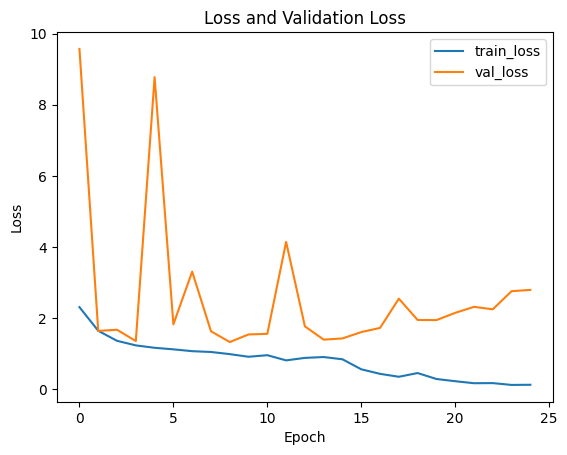

In [5]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.savefig('LossandValidationLoss.png')

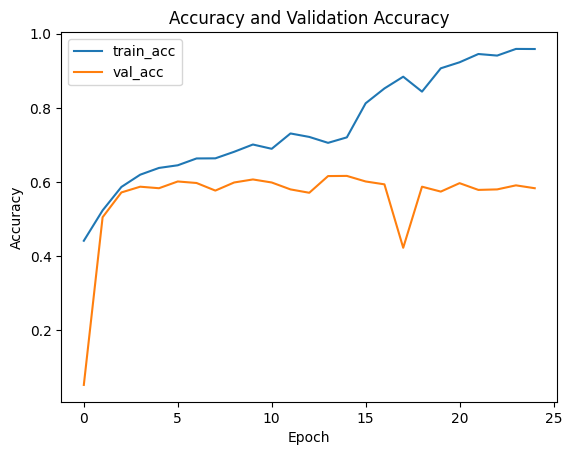

In [6]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('AccuracyandValidationAccuracy.png')